# Time constant effects for learning in time
In this notebook I intend to illustrate by the mean of visualization the effect of the time constant in the learning process when we are learning in time (k > 0). 

We start as usual by loading all the required libraries

In [1]:
from __future__ import print_function
import subprocess
import sys 
sys.path.append('../')

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.gridspec as gridspec

from mpl_toolkits.axes_grid1 import make_axes_locatable

from connectivity_functions import get_beta, get_w
from connectivity_functions import calculate_probability, calculate_coactivations
from data_transformer import build_ortogonal_patterns
from network import BCPNN

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec


%matplotlib inline
matplotlib.rcParams.update({'font.size': 22})

After this all the mechanisms for reading from the correct version control statement should be loaded

In [2]:
# Git

We first build the network and set the parameters, this should be controlled to see the effects on the plots bellow

In [3]:
hypercolumns = 3
minicolumns = 3
N = 3  # Number of patterns

patterns_dic = build_ortogonal_patterns(hypercolumns, minicolumns)
patterns = list(patterns_dic.values())
patterns = patterns[:N]

P_ideal = calculate_coactivations(patterns)
p_ideal = calculate_probability(patterns)

w_ideal = get_w(P_ideal, p_ideal)
beta_ideal = get_beta(p_ideal)

dt = 0.001
T_simulation = 2.0
T_training = 3.0
simulation_time = np.arange(0, T_simulation + dt, dt)
training_time = np.arange(0, T_training + dt, dt)

prng = np.random.RandomState(seed=0)


nn = BCPNN(hypercolumns, minicolumns, g_a=1, g_beta=1.0, g_w=1.0, g_I=10.0, prng=prng)

w_end = []
p_co_end = []

Then we load the trials

In [4]:
nn.empty_history()
nn.randomize_pattern()
nn.k = 1.0
aux_counter = 0 

for pattern in patterns:
    history = nn.run_network_simulation(training_time, I=pattern, save=True)
    w_end.append(history['w'][-1, ...])
    p_co_end.append(history['p_co'][-1, ...])
    
    aux_counter += 1

history = nn.history

In [8]:
o = history['o']
s = history['s']
z_pre = history['z_pre']
p_pre = history['p_pre']
p_post = history['p_post']
p_co = history['p_co']
beta = history['beta']
w = history['w']
adaptation = history['a']

distance_p = np.abs(p_pre - p_ideal)
distance_P = np.abs(p_co - P_ideal)
distance_w = np.abs(w - w_ideal)
print(distance_p.shape)

(9003, 9)


##### Plot the history

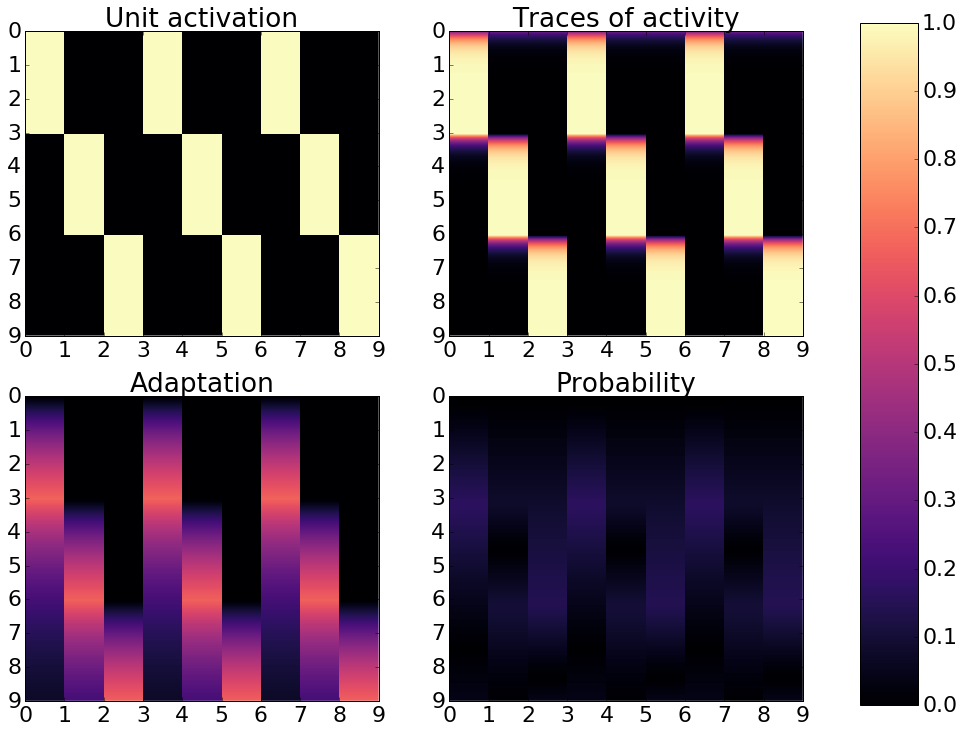

In [9]:
cmap = 'magma'
extent = [0, minicolumns * hypercolumns, aux_counter * T_training, 0]

fig = plt.figure(figsize=(16, 12))

ax1 = fig.add_subplot(221)
im1 = ax1.imshow(o, aspect='auto', interpolation='None', cmap=cmap, vmax=1, vmin=0, extent=extent)
ax1.set_title('Unit activation')

ax2 = fig.add_subplot(222)
im2 = ax2.imshow(z_pre, aspect='auto', interpolation='None', cmap=cmap, vmax=1, vmin=0, extent=extent)
ax2.set_title('Traces of activity')

ax3 = fig.add_subplot(223)
im3 = ax3.imshow(adaptation, aspect='auto', interpolation='None', cmap=cmap, vmax=1, vmin=0, extent=extent)
ax3.set_title('Adaptation')

ax4 = fig.add_subplot(224)
im4 = ax4.imshow(distance_p, aspect='auto', interpolation='None', cmap=cmap, vmax=1, vmin=0, extent=extent)
ax4.set_title('Probability')

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.12, 0.05, 0.79])
fig.colorbar(im1, cax=cbar_ax)

In [10]:
print('Final probability', nn.p_pre)

Final probability [ 0.28637096  0.33618309  0.37744595  0.28637612  0.33618231  0.37744157
  0.28635895  0.33617645  0.37746459]


#### Plot the final weight matrix

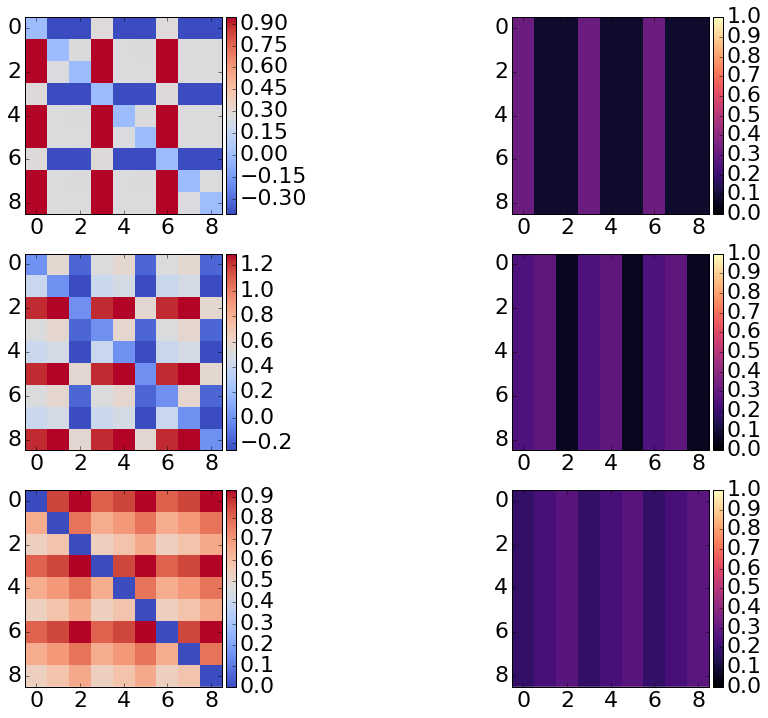

In [11]:
cmap1 = 'coolwarm'
cmap2 = 'magma'

gs = gridspec.GridSpec(aux_counter, 2)
fig = plt.figure(figsize=(16, 12))

for index, (w, p_co) in enumerate(zip(w_end, p_co_end)):

    ax = fig.add_subplot(gs[index, 0])
    im = ax.imshow(w, cmap=cmap1, interpolation='None')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, ax=ax, cax=cax)
    
    ax = fig.add_subplot(gs[index, 1])
    im = ax.imshow(p_co, cmap=cmap2, interpolation='None', vmin=0, vmax=1)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, ax=ax, cax=cax)

In [ ]:
T_retrieval = 1.0
retrieval_time = np.arange(0, T_retrieval + dt, dt)

# First empty the history
nn.empty_history()
# Run in retrival mode
nn.randomize_pattern()
nn.run_network_simulation(retrieval_time, I=None, save=True)

fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111)
im = ax.imshow(nn.history['o'], aspect='auto', cmap='magma', vmin=0, vmax=1)
plt.colorbar(im)

In [ ]:
nn.history['o'].shape

In [ ]:
n_trials = 10
final_patterns = []
for i in range(n_trials):
    nn.randomize_pattern()
    nn.k = 0
    nn.run_network_simulation(retrieval_time)
    final_patterns.append(nn.o)